In [112]:
%load_ext autoreload
%autoreload 2


from glob import glob
from itertools import chain, combinations
import math

import ensembl_rest
import numpy as np
import pandas as pd
from sourmash import load_signatures


import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.SubsMat import MatrixInfo as matlist

import seaborn as sns

In [3]:
GENCODE = "/home/olga/data_lg/czbiohub-reference/gencode"

In [7]:
ls $GENCODE/human/v30

gencode.v30.annotation.ERCC92.gene_type.gtf*
gencode.v30.annotation.ERCC92.gtf*
gencode.v30.annotation.gtf*
gencode.v30.pc_translations.fa.gz
gencode.v30.transcripts.ERCC92.fa*
gencode.v30.transcripts.fa*
getfasta_transcript_test.fa*
GRCh38.p12.genome.ERCC92.fa*
GRCh38.p12.genome.fa*
GRCh38.p12.genome.fa.fai*
Makefile*
Makefile~*
salmon_index/
STARIndex/
test_gffread_transcripts.fa*
test_gffread_transcripts_no_dashF.fa*
w*


In [9]:
ls $GENCODE/mouse/vM21

gencode.vM21.annotation.ERCC92.gene_type.gtf*  GRCm38.p6.genome.ERCC92.fa.fai*
gencode.vM21.annotation.ERCC92.gtf*            GRCm38.p6.genome.fa*
gencode.vM21.annotation.gtf*                   GRCm38.p6.genome.fa.fai*
gencode.vM21.pc_translations.fa.gz             GRCm38.p6.genome.fa.gz*
gencode.vM21.transcripts.ERCC92.fa*            Makefile*
gencode.vM21.transcripts.fa*                   Makefile~*
GRCm38.p6.genome.chr19.fa*                     STARIndex/
GRCm38.p6.genome.ERCC92.fa*


In [14]:
import gzip

def parse_fasta_gz(fasta_gz):
    with gzip.open(fasta_gz, "rt") as f:
        records = [(x.id, str(x.seq)) for x in SeqIO.parse(f, format='fasta')]
    return records

human_peptides = parse_fasta_gz(f"{GENCODE}/human/v30/gencode.v30.pc_translations.fa.gz")
print(f"len(human_peptides): {len(human_peptides)}")

mouse_peptides = parse_fasta_gz(f"{GENCODE}/mouse/vM21/gencode.vM21.pc_translations.fa.gz")
print(f"len(mouse_peptides): {len(mouse_peptides)}")

len(human_peptides): 99731
len(mouse_peptides): 66650


In [16]:
human_peptides[:2]

[('ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326',
  'MKKVTAEAISWNESTSETNNSMVTEFIFLGLSDSQELQTFLFMLFFVFYGGIVFGNLLIVITVVSDSHLHSPMYFLLANLSLIDLSLSSVTAPKMITDFFSQRKVISFKGCLVQIFLLHFFGGSEMVILIAMGFDRYIAICKPLHYTTIMCGNACVGIMAVTWGIGFLHSVSQLAFAVHLLFCGPNEVDSFYCDLPRVIKLACTDTYRLDIMVIANSGVLTVCSFVLLIISYTIILMTIQHRPLDKSSKALSTLTAHITVVLLFFGPCVFIYAWPFPIKSLDKFLAVFYSVITPLLNPIIYTLRNKDMKTAIRQLRKWDAHSSVKF'),
 ('ENSP00000334393.3|ENST00000335137.4|ENSG00000186092.6|OTTHUMG00000001094.4|-|OR4F5-201|OR4F5|305',
  'MVTEFIFLGLSDSQELQTFLFMLFFVFYGGIVFGNLLIVITVVSDSHLHSPMYFLLANLSLIDLSLSSVTAPKMITDFFSQRKVISFKGCLVQIFLLHFFGGSEMVILIAMGFDRYIAICKPLHYTTIMCGNACVGIMAVTWGIGFLHSVSQLAFAVHLLFCGPNEVDSFYCDLPRVIKLACTDTYRLDIMVIANSGVLTVCSFVLLIISYTIILMTIQHRPLDKSSKALSTLTAHITVVLLFFGPCVFIYAWPFPIKSLDKFLAVFYSVITPLLNPIIYTLRNKDMKTAIRQLRKWDAHSSVKF')]

In [20]:
DAYHOFF_MAPPING = {
    "C": "a",
    
    # Small
    "A": "b",
    "G": "b",
    "P": "b",
    "S": "b",
    "T": "b",
    
    # Acid and amide
    "D": "c",
    "E": "c",
    "N": "c",
    "Q": "c",
    
    # Basic
    "H": "d",
    "K": "d",
    "R": "d",
    
    # Hydrophobic
    "I": "e",
    "L": "e",
    "M": "e",
    "V": "e",
    
    # Aromatic
    "F": "f",
    "W": "f",
    "Y": "f"
}

## Hydrophobic/hydrophilic mapping
HP_MAPPING = {
    # Hydrophobic
    "A": "h",
    "F": "h",
    "G": "h",
    "I": "h",
    "L": "h",
    "M": 'h',
    "P": "h",
    "V": "h",
    "W": "h",
    "Y": "h",
    
    # Hydrophilic - polar
    "N": 'p',
    "C": 'p',
    "G": "p",
    "S": "p",
    "T": "p",
    "D": "p",
    "E": "p",
    "R": "p",
    "H": "p",
    "K": "p",
    "Q": "p"
}
len(HP_MAPPING)

20

In [25]:
DAYHOFF_TRANSLATION = str.maketrans(DAYHOFF_MAPPING)

HP_TRANSLATION = str.maketrans(HP_MAPPING)

def dayhoffize(seq):
    return seq.translate(DAYHOFF_TRANSLATION)

def hpize(seq):
    return seq.translate(HP_TRANSLATION)

seq = "MKKVTAEAISWNESTSETN"
print(seq)
print(dayhoffize(seq))
print(hpize(seq))

MKKVTAEAISWNESTSETN
eddebbcbebfccbbbcbc
hpphphphhphpppppppp


 | Amino acid    | Property              | Dayhoff |
 |---------------|-----------------------|---------|
 | C             | Sulfur polymerization | a       |
 | A, G, P, S, T | Small                 | b       |
 | D, E, N, Q    | Acid and amide        | c       |
 | H, K, R       | Basic                 | d       |
 | I, L, M, V    | Hydrophobic           | e       |
 | F, W, Y       | Aromatic              | f       |


In [142]:
%%time

KSIZES = 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
COLUMNS = 'id1', 'id2', 'ksize', 'jaccard'

def kmerize(seq, ksize):
    return set(seq[i:i+ksize] for i in range(len(seq)-ksize+1))

def jaccardize(set1, set2):
    denominator = min(len(set1), len(set2))
    if denominator > 0:
        return len(set1.intersection(set2))/denominator
    else:
        return denominator

def kmerize_and_jaccard(seq1, seq2, ksize, debug=False):
    kmers1 = set(seq1[i:i+ksize] for i in range(len(seq1)-ksize+1))
    kmers2 = set(seq2[i:i+ksize] for i in range(len(seq2)-ksize+1))
    jaccard = jaccardize(kmers1, kmers2)
    if debug:
        print("len(kmers1):", len(kmers1))
        print("len(kmers2):", len(kmers2))
        print(f"jaccard: {jaccard}")
    return jaccard


def kmer_comparison_table(id1, seq1, id2, seq2, molecule, ksizes=KSIZES):
    lines = []
    for ksize in ksizes:
        jaccard = kmerize_and_jaccard(seq1, seq2, ksize)
        line = [id1, id2, ksize, jaccard]
        lines.append(line)
    df = pd.DataFrame(lines, columns=COLUMNS)
    df['molecule'] = molecule
    return df

n_seqs = 100

human_subset = human_peptides[:n_seqs]
mouse_subset = mouse_peptides[:n_seqs]

input_seqs = [human_subset, mouse_subset]
seqs = chain(*input_seqs)

def nCr(n, r):
    f = math.factorial
    return f(n) // (f(r) * f(n - r))

total = nCr(len(input_seqs), 2)



dfs = []
for (id1, seq1), (id2, seq2) in tqdm.tqdm(combinations(seqs, 2), total=total):
    protein_df = kmer_comparison_table(id1, seq1, id2, seq2, molecule='protein')
    
    dayhoff1 = dayhoffize(seq1)
    dayhoff2 = dayhoffize(seq2)
    
    dayhoff_df = kmer_comparison_table(id1, dayhoff1, id2, dayhoff2, 
                                       molecule='dayhoff')
    
    hp1 = hpize(seq1)
    hp2 = hpize(seq2) 
    
    hp_df = kmer_comparison_table(id1, hp1, id2, hp2, 
                                       molecule='hydrophilic-polar')
    df = pd.concat([protein_df, dayhoff_df, hp_df], ignore_index=True)
    dfs.append(df)
peptide_kmer_comparisons = pd.concat(dfs, ignore_index=True)
print(peptide_kmer_comparisons.shape)
peptide_kmer_comparisons.head()


  0%|          | 0/1 [00:00<?, ?it/s]
6it [00:00, 56.94it/s]               
13it [00:00, 59.55it/s]
19it [00:00, 59.15it/s]
26it [00:00, 60.54it/s]
34it [00:00, 62.82it/s]
40it [00:00, 53.92it/s]
49it [00:00, 60.70it/s]
57it [00:00, 64.02it/s]
65it [00:01, 67.90it/s]
73it [00:01, 70.64it/s]
83it [00:01, 75.96it/s]
91it [00:01, 71.69it/s]
99it [00:01, 69.46it/s]
107it [00:01, 63.19it/s]
116it [00:01, 68.21it/s]
124it [00:01, 71.09it/s]
132it [00:01, 73.24it/s]
140it [00:02, 71.87it/s]
148it [00:02, 64.53it/s]
155it [00:02, 61.41it/s]
163it [00:02, 64.30it/s]
171it [00:02, 66.64it/s]
178it [00:02, 64.23it/s]
185it [00:02, 64.32it/s]
192it [00:02, 65.03it/s]
200it [00:02, 68.65it/s]
207it [00:03, 67.03it/s]
214it [00:03, 65.52it/s]
221it [00:03, 64.34it/s]
228it [00:03, 65.12it/s]
235it [00:03, 55.64it/s]
243it [00:03, 60.35it/s]
250it [00:03, 58.43it/s]
258it [00:03, 63.27it/s]
266it [00:04, 66.58it/s]
275it [00:04, 70.81it/s]
284it [00:04, 73.34it/s]
292it [00:04, 71.80it/s]
300it [00:

(1014900, 5)
CPU times: user 5min 32s, sys: 5.92 s, total: 5min 38s
Wall time: 5min 23s


In [143]:
(13.9/1000**2) * 10000**2

1390.0

In [144]:
len(dfs)

19900

In [145]:
# (1.33/100) * (len(human_peptides) + len(mouse_peptides))*/60/60

In [146]:
peptide_kmer_comparisons.shape

(1014900, 5)

In [147]:
peptide_kmer_comparisons.head()

,id1,id2,ksize,jaccard,molecule
0,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,2,1.0,protein
1,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,3,1.0,protein
2,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,4,1.0,protein
3,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,5,1.0,protein
4,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,6,1.0,protein


In [148]:
peptide_kmer_comparisons.id1.head().values

array(['ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326',
       'ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326',
       'ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326',
       'ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326',
       'ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326'],
      dtype=object)

In [182]:
gene_metadata = peptide_kmer_comparisons.id1.drop_duplicates().str.split("|", expand=True)
gene_metadata.index = peptide_kmer_comparisons.id1.unique()

columns = ['protein_id', 'transcript_id', 'gene_id', 
           'ott_gene', 'ott_transcript', 
           'transcript_name', 'gene_name', 'peptide_length']
renamer = dict(zip(range(len(columns)), columns))
gene_metadata = gene_metadata.rename(columns=renamer)
print(gene_metadata.shape)
gene_metadata.head()

(199, 8)


,protein_id,transcript_id,gene_id,ott_gene,ott_transcript,transcript_name,gene_name,peptide_length
ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326,ENSP00000493376.2,ENST00000641515.2,ENSG00000186092.6,OTTHUMG00000001094.4,OTTHUMT00000003223.4,OR4F5-202,OR4F5,326
ENSP00000334393.3|ENST00000335137.4|ENSG00000186092.6|OTTHUMG00000001094.4|-|OR4F5-201|OR4F5|305,ENSP00000334393.3,ENST00000335137.4,ENSG00000186092.6,OTTHUMG00000001094.4,-,OR4F5-201,OR4F5,305
ENSP00000409316.1|ENST00000426406.3|ENSG00000284733.1|OTTHUMG00000002860.3|OTTHUMT00000007999.3|OR4F29-201|OR4F29|312,ENSP00000409316.1,ENST00000426406.3,ENSG00000284733.1,OTTHUMG00000002860.3,OTTHUMT00000007999.3,OR4F29-201,OR4F29,312
ENSP00000329982.2|ENST00000332831.4|ENSG00000284662.1|OTTHUMG00000002581.3|OTTHUMT00000007334.3|OR4F16-201|OR4F16|312,ENSP00000329982.2,ENST00000332831.4,ENSG00000284662.1,OTTHUMG00000002581.3,OTTHUMT00000007334.3,OR4F16-201,OR4F16,312
ENSP00000411579.2|ENST00000420190.6|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000316521.3|SAMD11-203|SAMD11|358,ENSP00000411579.2,ENST00000420190.6,ENSG00000187634.12,OTTHUMG00000040719.11,OTTHUMT00000316521.3,SAMD11-203,SAMD11,358


In [150]:
gene_metadata.gene_name.unique()

array(['OR4F5', 'OR4F29', 'OR4F16', 'SAMD11', 'NOC2L', 'KLHL17',
       'PLEKHN1', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'RNF223', 'C1orf159',
       'TTLL10', 'TNFRSF18', 'TNFRSF4', 'SDF4', 'B3GALT6', 'C1QTNF12',
       'UBE2J2', 'SCNN1D', 'ACAP3', 'PUSL1', 'INTS11', 'Xkr4', 'Rp1',
       'Sox17', 'Mrpl15', 'Lypla1', 'Gm37988', 'Tcea1', 'Rgs20',
       'Atp6v1h', 'Oprk1', 'Npbwr1', 'Rb1cc1', 'Alkal1', 'St18', 'Pcmtd1',
       'Sntg1', 'Rrs1', 'Adhfe1', 'Vxn', 'Mybl1', 'Vcpip1', 'Sgk3',
       'Mcmdc2', 'Tcf24', 'Ppp1r42'], dtype=object)

In [151]:
gene_metadata.gene_name.nunique()

49

In [152]:
gene_metadata.gene_name.str.lower().nunique()

49

In [153]:
len(human_peptides[0][1])

326

In [154]:
gene_metadata = peptide_kmer_comparisons.id1

In [155]:
peptide_kmer_comparisons.id1.nunique()

199

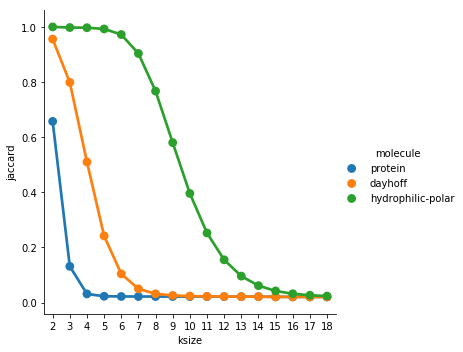

In [161]:
sns.catplot('ksize', 'jaccard', data=peptide_kmer_comparisons, hue='molecule', 
            kind='point')

### Add small random number for jittering to make 

In [165]:
peptide_kmer_comparisons['jaccard_kdeable'] = \
    peptide_kmer_comparisons['jaccard'] + np.random.normal(loc=0, scale=1e-10, 
                                                           size=len(peptide_kmer_comparisons))
peptide_kmer_comparisons.head()

,id1,id2,ksize,jaccard,molecule,jaccard_kdeable
0,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,2,1.0,protein,1.0
1,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,3,1.0,protein,1.0
2,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,4,1.0,protein,1.0
3,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,5,1.0,protein,1.0
4,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,6,1.0,protein,1.0


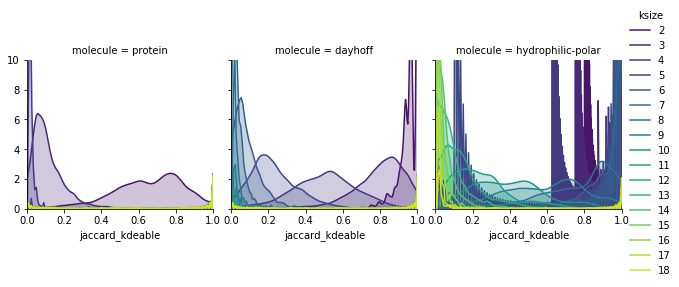

In [166]:

g = sns.FacetGrid(peptide_kmer_comparisons, col='molecule', hue='ksize', 
                  palette='viridis')
g.map(sns.kdeplot, 'jaccard_kdeable', shade=True)
g.set(xlim=(0, 1), ylim=(0, 10))
g.add_legend()

In [171]:
# sns.violinplot?

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


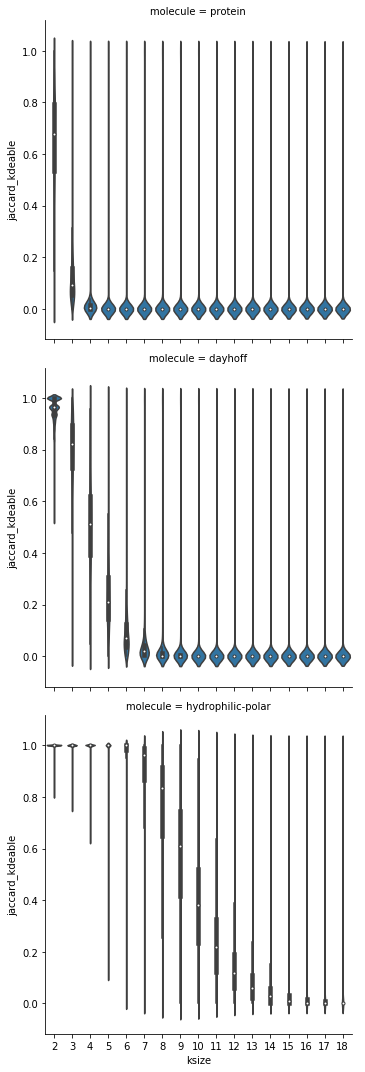

In [173]:

g = sns.FacetGrid(peptide_kmer_comparisons, row='molecule', 
                  palette='viridis', size=5)
g.map(sns.violinplot, 'ksize', 'jaccard_kdeable')
# g.set(xlim=(0, 1), ylim=(0, 10))
g.add_legend()

## There's still pretty high similarity when ksize > 9

In [184]:
pd.options.display.max_colwidth = 500

In [189]:
high_ksize_high_similarity = peptide_kmer_comparisons.query('(ksize >= 9) & (jaccard > 0.5) & (jaccard < 1)')
high_ksize_high_similarity = high_ksize_high_similarity.join(gene_metadata, on='id1')
high_ksize_high_similarity = high_ksize_high_similarity.drop_duplicates(subset=['id1', 'id2'])
print(high_ksize_high_similarity.shape)
high_ksize_high_similarity.head(20)

(12368, 14)


,id1,id2,ksize,jaccard,molecule,jaccard_kdeable,protein_id,transcript_id,gene_id,ott_gene,ott_transcript,transcript_name,gene_name,peptide_length
92,ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326,ENSP00000409316.1|ENST00000426406.3|ENSG00000284733.1|OTTHUMG00000002860.3|OTTHUMT00000007999.3|OR4F29-201|OR4F29|312,9,0.618605,hydrophilic-polar,0.618605,ENSP00000493376.2,ENST00000641515.2,ENSG00000186092.6,OTTHUMG00000001094.4,OTTHUMT00000003223.4,OR4F5-202,OR4F5,326
143,ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326,ENSP00000329982.2|ENST00000332831.4|ENSG00000284662.1|OTTHUMG00000002581.3|OTTHUMT00000007334.3|OR4F16-201|OR4F16|312,9,0.618605,hydrophilic-polar,0.618605,ENSP00000493376.2,ENST00000641515.2,ENSG00000186092.6,OTTHUMG00000001094.4,OTTHUMT00000003223.4,OR4F5-202,OR4F5,326
296,ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326,ENSP00000342313.3|ENST00000342066.8|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000276866.3|SAMD11-202|SAMD11|681,9,0.724138,hydrophilic-polar,0.724138,ENSP00000493376.2,ENST00000641515.2,ENSG00000186092.6,OTTHUMG00000001094.4,OTTHUMT00000003223.4,OR4F5-202,OR4F5,326
347,ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326,ENSP00000480870.1|ENST00000618181.4|ENSG00000187634.12|OTTHUMG00000040719.11|-|SAMD11-213|SAMD11|556,9,0.620690,hydrophilic-polar,0.620690,ENSP00000493376.2,ENST00000641515.2,ENSG00000186092.6,OTTHUMG00000001094.4,OTTHUMT00000003223.4,OR4F5-202,OR4F5,326
398,ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326,ENSP00000482138.1|ENST00000622503.4|ENSG00000187634.12|OTTHUMG00000040719.11|-|SAMD11-217|SAMD11|682,9,0.728448,hydrophilic-polar,0.728448,ENSP00000493376.2,ENST00000641515.2,ENSG00000186092.6,OTTHUMG00000001094.4,OTTHUMT00000003223.4,OR4F5-202,OR4F5,326
551,ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326,ENSP00000484256.1|ENST00000618779.4|ENSG00000187634.12|OTTHUMG00000040719.11|-|SAMD11-215|SAMD11|619,9,0.698276,hydrophilic-polar,0.698276,ENSP00000493376.2,ENST00000641515.2,ENSG00000186092.6,OTTHUMG00000001094.4,OTTHUMT00000003223.4,OR4F5-202,OR4F5,326
602,ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326,ENSP00000484643.1|ENST00000616125.4|ENSG00000187634.12|OTTHUMG00000040719.11|-|SAMD11-211|SAMD11|573,9,0.629310,hydrophilic-polar,0.629310,ENSP00000493376.2,ENST00000641515.2,ENSG00000186092.6,OTTHUMG00000001094.4,OTTHUMT00000003223.4,OR4F5-202,OR4F5,326
704,ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326,ENSP00000482090.1|ENST00000617307.4|ENSG00000187634.12|OTTHUMG00000040719.11|-|SAMD11-212|SAMD11|601,9,0.633621,hydrophilic-polar,0.633621,ENSP00000493376.2,ENST00000641515.2,ENSG00000186092.6,OTTHUMG00000001094.4,OTTHUMT00000003223.4,OR4F5-202,OR4F5,326
755,ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326,ENSP00000349216.4|ENST00000341065.8|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000097860.4|SAMD11-201|SAMD11|589,9,0.693966,hydrophilic-polar,0.693966,ENSP00000493376.2,ENST00000641515.2,ENSG00000186092.6,OTTHUMG00000001094.4,OTTHUMT00000003223.4,OR4F5-202,OR4F5,326
806,ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326,ENSP00000412228.1|ENST00000455979.1|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000097863.4|SAMD11-205|SAMD11|541,9,0.702586,hydrophilic-polar,0.702586,ENSP00000493376.2,ENST00000641515.2,ENSG00000186092.6,OTTHUMG00000001094.4,OTTHUMT00000003223.4,OR4F5-202,OR4F5,326


In [200]:
seq1 = id_to_seq['ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326']
seq1[:10]

'MKKVTAEAIS'

In [201]:
seq2 = id_to_seq['ENSP00000342313.3|ENST00000342066.8|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000276866.3|SAMD11-202|SAMD11|681']
seq2[:10]

'MSKGILQVHP'

In [213]:
matrix = matlist.blosum62

colwidth = 100

petpide_alignments = pairwise2.align.globaldx(seq1, seq2, matrix, one_alignment_only=True)
for a in petpide_alignments:
    chunksize, extra = divmod(len(a[0]), colwidth)
    if extra:
        chunksize += 1
    for i in range(chunksize):
        start = i * chunksize
        end = min(start + colwidth, len(a[0]))
        print(a[0][start:end])
        print(a[1][start:end])
        print()

M-K---KVTA-----EA-----ISW---N-----ES--T-S---------E-TNN-SMVTEFIFL----GL-SD-S-----------QE----LQTFLFM
MSKGILQV--HPPICD-CPGCRIS-SPVNRGRLAD-KRTVALPAARNLKKERT--PS------F-SASDG-DSDGSGPTCGRRPGLKQEDGPHIR--I-M

A-----EA-----ISW---N-----ES--T-S---------E-TNN-SMVTEFIFL----GL-SD-S-----------QE----LQTFLFMLFF---VFY
-HPPICD-CPGCRIS-SPVNRGRLAD-KRTVALPAARNLKKERT--PS------F-SASDG-DSDGSGPTCGRRPGLKQEDGPHIR--I-M---KRRV-H

----ISW---N-----ES--T-S---------E-TNN-SMVTEFIFL----GL-SD-S-----------QE----LQTFLFMLFF---VFYGG----I-V
PGCRIS-SPVNRGRLAD-KRTVALPAARNLKKERT--PS------F-SASDG-DSDGSGPTCGRRPGLKQEDGPHIR--I-M---KRRV-H--THWDVNI

-N-----ES--T-S---------E-TNN-SMVTEFIFL----GL-SD-S-----------QE----LQTFLFMLFF---VFYGG----I-V-F-------
VNRGRLAD-KRTVALPAARNLKKERT--PS------F-SASDG-DSDGSGPTCGRRPGLKQEDGPHIR--I-M---KRRV-H--THWDVNISFREASCSQ

--T-S---------E-TNN-SMVTEFIFL----GL-SD-S-----------QE----LQTFLFMLFF---VFYGG----I-V-F--------GNLLIVI-
KRTVALPAARNLKKERT--PS------F-SASDG-DSDGSGPTCGRRPGLKQEDGPHIR--I-M---KRRV-H--THWDVNISFREA

#### Wow these two proteins are pretty different but had a very high "hp" score ...


Let's ignore "hp" for now

In [207]:
a[0][:50]

'M-K---KVT----AE--A--ISW---N-----ES--T-S---------E-'

In [206]:
a

('M-K---KVT----AE--A--ISW---N-----ES--T-S---------E-TNN-SMVTEFIFL----GL-SD-S-----------QE----LQTFLFMLFF---VFYGG----I-V-F--------GNLLIVI-TVVSDS-HL---HS---PM-Y-----FLLANL---SL-I------DLSLS------SVTAPKMIT-DF-FSQ-R-KVISFKGCLV--Q--IFLLHFFG----G-S---E-----MVI--LI--AMG--F-D--R-Y-IA-IC----K-P--------L--HYTT----I--------MC-GN-ACVGIM-A-V---TW-GI-----GFL--H----------SV-S-----Q---L-AF---AV-H--L---L---F-------C---G----PN----EVDSF-YC--DLP-RVIK--LACTDTYRL----DIM----V------I-A-------NS-GV---LTVC----SFVLLIISYTII----LMT-I--QHR-PL----------D-------K------S---S--K----A-L-----S-------TL------TAH-I-----TVVL---------------LFF-G---PCV-FI-YAW--P-F---------------P----I-K-SLDK----F---LAVF----YS-V-----I---T-PLL-------N------P---I---I--------Y-------------TLRN---KDMK-TAIR--Q-LRKWD----A-------HS-----SV-KF--------------------',
 'MSKGILQV-HPPICDCPGCRIS-SPVNRGRLAD-KRTVALPAARNLKKERT--PS------F-SASDG-DSDGSGPTCGRRPGLKQEDGPHIR--I-M---KRRV-H--THWDVNISFREASCSQDGN-L---PTLIS-SVH-RSRH-LVMP-EHQSRCEF-----QRGSLEIGLRPAGDL-L-GKRLG

In [193]:
hpize(id_to_seq['ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326'])

'hpphphphhphpppppppppphhpphhhhphppppphpphhhhhhhhhhpphhhpphhhhhphhpppphpphhhhhhhphphhphphpphphhphhpphhpppphhphppphhphhhhphhpppphhhhhhhphpphhhhpphhphpphhppphphphhhhphphphhpphpphhhhhphhhpphpphpphhpphhphhphhpppphphphhhhhppphhphpphhhhhhphphhhhphppphhppppphhpphphphphhhhhhphphhhhhhhhhhpphpphhhhhhphhphhhphhhhphpppphpphhpphpphphppphph'

In [192]:
hpize(id_to_seq['ENSP00000342313.3|ENST00000342066.8|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000276866.3|SAMD11-202|SAMD11|681'])

'hppphhphphhhppphppphpphhpppphhpppphhhhhhpphppppphphphppppppppphppppphphppppphphphhppphppphphphphpphppppppphhphhpphppppphhhhppppppphpppphphphphhpphhppphppphphpppphpppphpppphpphhhhhpphphphhhppphpphhphhpphpphpphpphhphphhppppphhhpphhpphhppphhphppphhhhhhpphpphphphhppphppppppphhppppphhhhhhhphpppphhphhhhhphpphhphhhphphphhhhphhphhppphphphhhhhphphhhhppphhpppphhphphhhphhpppphpphphphhhhpphhphppphpphpppphhhhhppphhhhhhhhhpphhppphhphpppphpphhpppphphhphphppppphpphphhhppppppphhppppppphpphhhpppphphpphhhpphphpppphhhppphhhphhhhhphhhppphhpphphpppphhhhpphpphphpphpphhpphppppphpphhpppphpppphhhhpppphhpphphphphhhphphphhpphpphhhhhphhhhhhhphhphphhppphppppphhphpphpphhpppphhhpppphpppppphhhhhphhphpphhp'

In [214]:
high_ksize_high_similarity = peptide_kmer_comparisons.query('(ksize >= 9) & (jaccard > 0.5) & (jaccard < 1) & (molecule != "hydrophilic-polar")')
high_ksize_high_similarity = high_ksize_high_similarity.join(gene_metadata, on='id1', rsuffix='_id1')
high_ksize_high_similarity = high_ksize_high_similarity.join(gene_metadata, on='id2', rsuffix='_id2')
high_ksize_high_similarity = high_ksize_high_similarity.drop_duplicates(subset=['id1', 'id2'])
print(high_ksize_high_similarity.shape)
high_ksize_high_similarity.head(20)

(216, 22)


,id1,id2,ksize,jaccard,molecule,jaccard_kdeable,protein_id,transcript_id,gene_id,ott_gene,...,gene_name,peptide_length,protein_id_id2,transcript_id_id2,gene_id_id2,ott_gene_id2,ott_transcript_id2,transcript_name_id2,gene_name_id2,peptide_length_id2
40552,ENSP00000411579.2|ENST00000420190.6|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000316521.3|SAMD11-203|SAMD11|358,ENSP00000478421.1|ENST00000616016.4|ENSG00000187634.12|OTTHUMG00000040719.11|-|SAMD11-210|SAMD11|345,9,0.507418,protein,0.507418,ENSP00000411579.2,ENST00000420190.6,ENSG00000187634.12,OTTHUMG00000040719.11,...,SAMD11,358,ENSP00000478421.1,ENST00000616016.4,ENSG00000187634.12,OTTHUMG00000040719.11,-,SAMD11-210,SAMD11,345
50293,ENSP00000393181.1|ENST00000437963.5|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000097862.5|SAMD11-204|SAMD11|109,ENSP00000480870.1|ENST00000618181.4|ENSG00000187634.12|OTTHUMG00000040719.11|-|SAMD11-213|SAMD11|556,9,0.752475,protein,0.752475,ENSP00000393181.1,ENST00000437963.5,ENSG00000187634.12,OTTHUMG00000040719.11,...,SAMD11,109,ENSP00000480870.1,ENST00000618181.4,ENSG00000187634.12,OTTHUMG00000040719.11,-,SAMD11-213,SAMD11,556
50599,ENSP00000393181.1|ENST00000437963.5|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000097862.5|SAMD11-204|SAMD11|109,ENSP00000484820.1|ENST00000620200.4|ENSG00000187634.12|OTTHUMG00000040719.11|-|SAMD11-216|SAMD11|226,9,0.920792,protein,0.920792,ENSP00000393181.1,ENST00000437963.5,ENSG00000187634.12,OTTHUMG00000040719.11,...,SAMD11,109,ENSP00000484820.1,ENST00000620200.4,ENSG00000187634.12,OTTHUMG00000040719.11,-,SAMD11-216,SAMD11,226
60136,ENSP00000342313.3|ENST00000342066.8|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000276866.3|SAMD11-202|SAMD11|681,ENSP00000480870.1|ENST00000618181.4|ENSG00000187634.12|OTTHUMG00000040719.11|-|SAMD11-213|SAMD11|556,9,0.956204,protein,0.956204,ENSP00000342313.3,ENST00000342066.8,ENSG00000187634.12,OTTHUMG00000040719.11,...,SAMD11,681,ENSP00000480870.1,ENST00000618181.4,ENSG00000187634.12,OTTHUMG00000040719.11,-,SAMD11-213,SAMD11,556
60187,ENSP00000342313.3|ENST00000342066.8|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000276866.3|SAMD11-202|SAMD11|681,ENSP00000482138.1|ENST00000622503.4|ENSG00000187634.12|OTTHUMG00000040719.11|-|SAMD11-217|SAMD11|682,9,0.988113,protein,0.988113,ENSP00000342313.3,ENST00000342066.8,ENSG00000187634.12,OTTHUMG00000040719.11,...,SAMD11,681,ENSP00000482138.1,ENST00000622503.4,ENSG00000187634.12,OTTHUMG00000040719.11,-,SAMD11-217,SAMD11,682
60289,ENSP00000342313.3|ENST00000342066.8|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000276866.3|SAMD11-202|SAMD11|681,ENSP00000478421.1|ENST00000616016.4|ENSG00000187634.12|OTTHUMG00000040719.11|-|SAMD11-210|SAMD11|345,9,0.673591,protein,0.673591,ENSP00000342313.3,ENST00000342066.8,ENSG00000187634.12,OTTHUMG00000040719.11,...,SAMD11,681,ENSP00000478421.1,ENST00000616016.4,ENSG00000187634.12,OTTHUMG00000040719.11,-,SAMD11-210,SAMD11,345
60340,ENSP00000342313.3|ENST00000342066.8|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000276866.3|SAMD11-202|SAMD11|681,ENSP00000484256.1|ENST00000618779.4|ENSG00000187634.12|OTTHUMG00000040719.11|-|SAMD11-215|SAMD11|619,9,0.986907,protein,0.986907,ENSP00000342313.3,ENST00000342066.8,ENSG00000187634.12,OTTHUMG00000040719.11,...,SAMD11,681,ENSP00000484256.1,ENST00000618779.4,ENSG00000187634.12,OTTHUMG00000040719.11,-,SAMD11-215,SAMD11,619
60391,ENSP00000342313.3|ENST00000342066.8|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000276866.3|SAMD11-202|SAMD11|681,ENSP00000484643.1|ENST00000616125.4|ENSG00000187634.12|OTTHUMG00000040719.11|-|SAMD11-211|SAMD11|573,9,0.971681,protein,0.971681,ENSP00000342313.3,ENST00000342066.8,ENSG00000187634.12,OTTHUMG00000040719.11,...,SAMD11,681,ENSP00000484643.1,ENST00000616125.4,ENSG00000187634.12,OTTHUMG00000040719.11,-,SAMD11-211,SAMD11,573
60493,ENSP00000342313.3|ENST00000342066.8|ENSG00000187634.12|OTTHUMG00000040719.11|OTTHUMT00000276866.3|SAMD11-202|SAMD11|681,ENSP00000482090.1|ENST00000617307.4|ENSG0

In [215]:
high_ksize_high_similarity.query("gene_name != gene_name_id2")

,id1,id2,ksize,jaccard,molecule,jaccard_kdeable,protein_id,transcript_id,gene_id,ott_gene,...,gene_name,peptide_length,protein_id_id2,transcript_id_id2,gene_id_id2,ott_gene_id2,ott_transcript_id2,transcript_name_id2,gene_name_id2,peptide_length_id2


In [176]:
id_to_seq = dict(mouse_peptides)
id_to_seq.update(dict(human_peptides))
id_to_seq['ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326']

'MKKVTAEAISWNESTSETNNSMVTEFIFLGLSDSQELQTFLFMLFFVFYGGIVFGNLLIVITVVSDSHLHSPMYFLLANLSLIDLSLSSVTAPKMITDFFSQRKVISFKGCLVQIFLLHFFGGSEMVILIAMGFDRYIAICKPLHYTTIMCGNACVGIMAVTWGIGFLHSVSQLAFAVHLLFCGPNEVDSFYCDLPRVIKLACTDTYRLDIMVIANSGVLTVCSFVLLIISYTIILMTIQHRPLDKSSKALSTLTAHITVVLLFFGPCVFIYAWPFPIKSLDKFLAVFYSVITPLLNPIIYTLRNKDMKTAIRQLRKWDAHSSVKF'

In [180]:
id_to_seq[high_ksize_high_similarity.id1.iloc[0]]

'MKKVTAEAISWNESTSETNNSMVTEFIFLGLSDSQELQTFLFMLFFVFYGGIVFGNLLIVITVVSDSHLHSPMYFLLANLSLIDLSLSSVTAPKMITDFFSQRKVISFKGCLVQIFLLHFFGGSEMVILIAMGFDRYIAICKPLHYTTIMCGNACVGIMAVTWGIGFLHSVSQLAFAVHLLFCGPNEVDSFYCDLPRVIKLACTDTYRLDIMVIANSGVLTVCSFVLLIISYTIILMTIQHRPLDKSSKALSTLTAHITVVLLFFGPCVFIYAWPFPIKSLDKFLAVFYSVITPLLNPIIYTLRNKDMKTAIRQLRKWDAHSSVKF'

In [181]:
id_to_seq[high_ksize_high_similarity.id2.iloc[0]]

'MVTEFIFLGLSDSQELQTFLFMLFFVFYGGIVFGNLLIVITVVSDSHLHSPMYFLLANLSLIDLSLSSVTAPKMITDFFSQRKVISFKGCLVQIFLLHFFGGSEMVILIAMGFDRYIAICKPLHYTTIMCGNACVGIMAVTWGIGFLHSVSQLAFAVHLLFCGPNEVDSFYCDLPRVIKLACTDTYRLDIMVIANSGVLTVCSFVLLIISYTIILMTIQHRPLDKSSKALSTLTAHITVVLLFFGPCVFIYAWPFPIKSLDKFLAVFYSVITPLLNPIIYTLRNKDMKTAIRQLRKWDAHSSVKF'

TypeError: can't multiply sequence by non-int of type 'float'

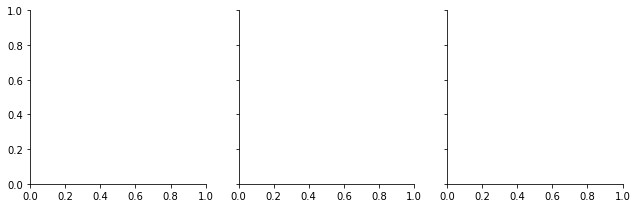

In [168]:

g = sns.FacetGrid(peptide_kmer_comparisons, col='molecule', hue='ksize', 
                  palette='viridis')
g.map(sns.kdeplot, 'jaccard_kdeable', shade=True, cut=(0, 1), bw=0.01)
g.set(xlim=(0, 1), ylim=(0, 10))
g.add_legend()


In [ ]:
g = sns.FacetGrid(peptide_kmer_comparisons, col='molecule', hue='ksize', 
                  palette='viridis')
g.map(sns.kdeplot, 'jaccard')
g.set(xlim=(0, 1), ylim=(0, 10))
g.add_legend()

In [69]:
np

NameError: name 'np' is not defined

In [68]:
peptide_kmer_comparisons_gr0 = peptide_kmer_comparisons.query('jaccard > 0')
print(peptide_kmer_comparisons_gr0.shape)
peptide_kmer_comparisons_gr0.head()

(1687, 5)


,id1,id2,ksize,jaccard,molecule
0,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSMUSP00000070648.4|ENSMUST00000070533.4|ENSM...,2,0.777202,protein
1,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSMUSP00000070648.4|ENSMUST00000070533.4|ENSM...,3,0.130719,protein
2,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSMUSP00000070648.4|ENSMUST00000070533.4|ENSM...,4,0.006211,protein
8,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSMUSP00000070648.4|ENSMUST00000070533.4|ENSM...,2,1.000000,dayhoff
9,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSMUSP00000070648.4|ENSMUST00000070533.4|ENSM...,3,0.883929,dayhoff


ValueError: zero-size array to reduction operation minimum which has no identity

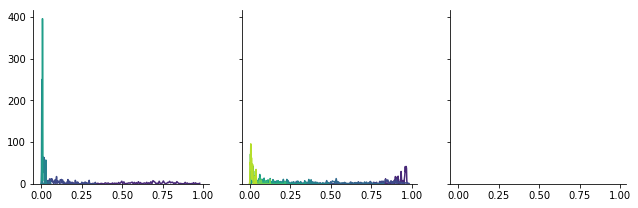

In [67]:
g = sns.FacetGrid(peptide_kmer_comparisons_gr0, col='molecule', hue='ksize', 
                  palette='viridis')
g.map(sns.kdeplot, 'jaccard', clip=(0, 1), bw=0.001)
g.set(xlim=(0, 1), ylim=(0, 10))
g.add_legend()

In [134]:
source_dayhoff = source_seq.translate(dayhoff_mapping)

In [136]:
ksizes = 2, 3, 4, 5, 6, 7, 8, 9

for ksize in ksizes:
    print(f"--- {ksize} ---")
    target_kmers = set(target_dayhoff[i:i+ksize] for i in range(len(target_dayhoff)-ksize+1))
    source_kmers = set(source_dayhoff[i:i+ksize] for i in range(len(source_dayhoff)-ksize+1))
    print("len(target_kmers):", len(target_kmers))
    print("len(source_kmers):", len(source_kmers))
    print("intersection:", len(target_kmers.intersection(source_kmers))/min(len(source_kmers), len(target_kmers)))

--- 2 ---
len(target_kmers): 32
len(source_kmers): 32
intersection: 1.0
--- 3 ---
len(target_kmers): 110
len(source_kmers): 111
intersection: 0.8363636363636363
--- 4 ---
len(target_kmers): 204
len(source_kmers): 222
intersection: 0.5980392156862745
--- 5 ---
len(target_kmers): 268
len(source_kmers): 283
intersection: 0.417910447761194
--- 6 ---
len(target_kmers): 290
len(source_kmers): 301
intersection: 0.29310344827586204
--- 7 ---
len(target_kmers): 295
len(source_kmers): 305
intersection: 0.2305084745762712
--- 8 ---
len(target_kmers): 296
len(source_kmers): 305
intersection: 0.18243243243243243
--- 9 ---
len(target_kmers): 296
len(source_kmers): 304
intersection: 0.14864864864864866


In [124]:
homology.keys()

dict_keys(['method_link_type', 'target', 'type', 'dn_ds', 'taxonomy_level', 'source'])

In [84]:
ensembl_rest.overlap_translation("ENSP00000467301")

[{'align_type': None,
  'interpro': '',
  'id': 'SSF81321',
  'Parent': 'ENST00000585993',
  'type': 'SuperFamily',
  'description': '',
  'cigar_string': '',
  'feature_type': 'protein_feature',
  'translation_id': 1589091,
  'hseqname': 'SSF81321',
  'start': 2,
  'seq_region_name': 'ENSP00000467301',
  'hit_start': 0,
  'hit_end': 0,
  'end': 297},
 {'interpro': 'IPR000276',
  'align_type': None,
  'id': 'PS00237',
  'cigar_string': '',
  'feature_type': 'protein_feature',
  'translation_id': 1589091,
  'hseqname': 'PS00237',
  'type': 'Prosite_patterns',
  'Parent': 'ENST00000585993',
  'description': 'G protein-coupled receptor, rhodopsin-like',
  'start': 103,
  'end': 119,
  'hit_end': 0,
  'seq_region_name': 'ENSP00000467301',
  'hit_start': 0},
 {'interpro': '',
  'align_type': None,
  'id': 'TMhelix',
  'type': 'TMHMM',
  'Parent': 'ENST00000585993',
  'description': '',
  'feature_type': 'protein_feature',
  'hseqname': 'TMhelix',
  'translation_id': 1589091,
  'cigar_string

In [79]:
target_protein_id = homology['target']['protein_id']
source_protein_id = homology['source']['protein_id']

target_sig = protein_id_to_signature[target_protein_id]
source_sig = protein_id_to_signature[source_protein_id]



In [80]:
target_sig.similarity(source_sig)

0.0

In [ ]:
for homology in homologies:


In [28]:
ensembl_rest.lookup("ENST00000641515")

{'db_type': 'core',
 'source': 'havana',
 'object_type': 'Transcript',
 'biotype': 'protein_coding',
 'logic_name': 'havana',
 'assembly_name': 'GRCh38',
 'seq_region_name': '1',
 'id': 'ENST00000641515',
 'is_canonical': 0,
 'start': 65419,
 'end': 71585,
 'Parent': 'ENSG00000186092',
 'version': 2,
 'display_name': 'OR4F5-202',
 'species': 'homo_sapiens',
 'strand': 1}

In [36]:
# ensembl_rest.homology_ensemblgene("ENSG00000186092", target_species='mus_musculus', type='orthologues')

In [44]:
import requests, sys
from pprint import pprint
 
server = "https://rest.ensembl.org"
ext = "/homology/id/ENSG00000157764?target_species=mouse;type=orthologues"
 
r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
 
if not r.ok:
    r.raise_for_status()
    sys.exit()

decoded = r.json()
# print(repr(decoded))
pprint(decoded)

{'data': [{'homologies': [{'dn_ds': 0.04787,
                           'method_link_type': 'ENSEMBL_ORTHOLOGUES',
                           'source': {'align_seq': '-------------------MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEEVWNIKQMIKLTQEHIEALLDKFGGEHNPPSIYLEAYEEYTSKLDALQQREQQLL-ESLGNGTDFSVSSSASMDTVTSSSSSSLSVLPSSLSVFQNPTDVARSNPKSPQKPIVRVFLPNKQRTVVPARCGVTVRDSLKKALMMRGLIPECCAVYRIQDG-EKKPIGWDTDISWLTGEELHVEVLENVPLTTHNFVRKTFFTLAFCDFCRKLLFQGFRCQTCGYKFHQRCSTEVPLMCVNYDQLDLLFVSKFFEHHPIPQEEASLAETALTSGSSPSAPASDSIGPQILTSPSPSKSIPIPQPFRPADEDHRNQFGQRDRSSSAPNVHINTIEPVNIDD-------------LIRDQGFRGDG----------------------------------------GSTTGLSATPPASLPGSLTNVKALQKSPGPQRERKSSSSS--EDRNRMKTLGRRDSSDDWEIPDGQITVGQRIGSGSFGTVYKGKWHGDVAVKMLNVTAPTPQQLQAFKNEVGVLRKTRHVNILLFMGYSTKPQLAIVTQWCEGSSLYHHLHIIETKFEMIKLIDIARQTAQGMDYLHAKSIIHRDLKSNNIFLHEDLTVKIGDFGLATVKSRWSGSHQFEQLSGSILWMAPEVIRMQDKNPYSFQSDVYAFGIVLYELMTGQLPYSNINNRDQIIFMVGRGYLSPDLSKVRSNCPKAMKRLMAECLKKKRDERPLFPQILASIELLARSLPKIHRSASEPSLNRAGFQTEDFSLYACASPKTPIQA

In [ ]:
pprint()

In [ ]:
import requests, sys
 
server = "https://rest.ensembl.org"
ext = "/homology/id/ENSG00000157764?target_species=mouse;type=orthologues"
 
r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
 
if not r.ok:
    r.raise_for_status()
    sys.exit()

decoded = r.json()
print(repr(decoded))

In [37]:
import requests, sys
 
server = "http://rest.ensembl.org"
ext = "/homology/id/human/ENSG00000186092?format=condensed;target_species=mouse;type=orthologues"
 
r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
 
if not r.ok:
  r.raise_for_status()
  sys.exit()
 
decoded = r.json()
print(repr(decoded))
 

HTTPError: 404 Client Error: Not Found for url: http://rest.ensembl.org/homology/id/human/ENSG00000186092?format=condensed;target_species=mouse;type=orthologues

In [19]:
gene_id_with_orthology = 'ENSG00000198888'

In [20]:
ensembl_rest.lookup(gene_id_with_orthology)

{'biotype': 'protein_coding',
 'strand': 1,
 'display_name': 'MT-ND1',
 'version': 2,
 'species': 'homo_sapiens',
 'end': 4262,
 'object_type': 'Gene',
 'start': 3307,
 'source': 'insdc',
 'description': 'mitochondrially encoded NADH:ubiquinone oxidoreductase core subunit 1 [Source:HGNC Symbol;Acc:HGNC:7455]',
 'id': 'ENSG00000198888',
 'seq_region_name': 'MT',
 'db_type': 'core',
 'logic_name': 'mt_genbank_import',
 'assembly_name': 'GRCh38'}

In [25]:
ensembl_rest.overlap_region(gene_id_with_orthology)

HTTPError: Server returned HTTP status code: 404
Content: {'error': 'page not found. Please check your uri and refer to our documentation https://rest.ensembl.org/'}

In [21]:
ensembl_rest.xref_id(gene_id_with_orthology, all_levels=True)

[{'info_text': '',
  'version': '0',
  'display_id': 'ENSG00000198888',
  'description': None,
  'synonyms': [],
  'primary_id': 'ENSG00000198888',
  'info_type': 'DIRECT',
  'db_display_name': 'Expression Atlas',
  'dbname': 'ArrayExpress'},
 {'dbname': 'EntrezGene',
  'db_display_name': 'NCBI gene',
  'synonyms': [],
  'primary_id': '4535',
  'info_type': 'DEPENDENT',
  'description': 'NADH dehydrogenase, subunit 1 (complex I)',
  'info_text': '',
  'display_id': 'ND1',
  'version': '0'},
 {'display_id': 'MT-ND1',
  'version': '0',
  'info_text': 'Generated via ensembl_manual',
  'description': 'mitochondrially encoded NADH:ubiquinone oxidoreductase core subunit 1',
  'info_type': 'DIRECT',
  'synonyms': ['MTND1', 'NAD1', 'ND1'],
  'primary_id': 'HGNC:7455',
  'dbname': 'HGNC',
  'db_display_name': 'HGNC Symbol'},
 {'dbname': 'MIM_GENE',
  'db_display_name': 'MIM gene',
  'synonyms': [],
  'primary_id': '516000',
  'info_type': 'DEPENDENT',
  'description': 'COMPLEX I, SUBUNIT ND1; M

In [15]:
ensembl_rest.homology_ensemblgene(key)

{'data': []}

{'data': []}

In [25]:
orthologues = pd.read_csv("s3://kmer-hashing/hg38_mm38_protein_coding/hg38_mm38_ensembl_compara_orthologues.txt", sep='\t')
print(orthologues.shape)
orthologues.head()

(249084, 15)


,Gene stable ID,Transcript stable ID,Mouse gene stable ID,Mouse gene name,Mouse protein or transcript stable ID,Mouse homology type,%id. target Mouse gene identical to query gene,%id. query gene identical to target Mouse gene,Mouse Gene-order conservation score,Mouse Whole-genome alignment coverage,dS with Mouse,dN with Mouse,"Mouse orthology confidence [0 low, 1 high]",Last common ancestor with Mouse,Query protein or transcript ID
0,ENSG00000210049,ENST00000387314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000211459,ENST00000389680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000210077,ENST00000387342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSG00000210082,ENST00000387347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000209082,ENST00000386347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
